# Binary Classification of Machine Failures
The dataset was generated from a deep learning model trained on the Machine Failure Predictions in [Kaggle](https://www.kaggle.com/c/playground-series-s3e17).

## Install Libraries

In [ ]:
!pip install catboost
!pip install category-encoders

from category_encoders import MEstimateEncoder

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, cross_val_score

from imblearn.over_sampling import RandomOverSampler

from google.colab import drive
import os

import warnings

%matplotlib inline

SEED = 42
n_splits=3

# Set Matplotlib defaults
plt.rcParams['figure.figsize'] = [3, 3]
plt.rcParams['image.cmap'] = 'magma'

warnings.filterwarnings("ignore") # to clean up output cells

In [ ]:
n_splits=3

## Import Dataset

In [ ]:
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/"

Mounted at /content/gdrive


In [ ]:
!kaggle competitions download -c playground-series-s3e17
!unzip \*.zip  && rm *.zip

 86% 3.00M/3.49M [00:00<00:00, 5.58MB/s]
100% 3.49M/3.49M [00:00<00:00, 5.38MB/s]
Archive:  playground-series-s3e17.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


## Exploratory Data Analysis

In [ ]:
# Load data
data = pd.read_csv('train.csv')
data.drop('id', axis=1, inplace=True)
print(f"Data shape is {data.shape}")

Data shape is (136429, 13)


### Understanding the big picture

In [ ]:
data.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136429 entries, 0 to 136428
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Product ID               136429 non-null  object 
 1   Type                     136429 non-null  object 
 2   Air temperature [K]      136429 non-null  float64
 3   Process temperature [K]  136429 non-null  float64
 4   Rotational speed [rpm]   136429 non-null  int64  
 5   Torque [Nm]              136429 non-null  float64
 6   Tool wear [min]          136429 non-null  int64  
 7   Machine failure          136429 non-null  int64  
 8   TWF                      136429 non-null  int64  
 9   HDF                      136429 non-null  int64  
 10  PWF                      136429 non-null  int64  
 11  OSF                      136429 non-null  int64  
 12  RNF                      136429 non-null  int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 13.5+ MB


In [ ]:
# Summarizes the count, mean, standard deviation, min, and max for numeric variables.
data.describe().T.apply(lambda s: s.apply(lambda x: format(x, 'f')))

,count,mean,std,min,25%,50%,75%,max
Air temperature [K],136429.000000,299.862776,1.862247,295.300000,298.300000,300.000000,301.200000,304.400000
Process temperature [K],136429.000000,309.941070,1.385173,305.800000,308.700000,310.000000,310.900000,313.800000
Rotational speed [rpm],136429.000000,1520.331110,138.736632,1181.000000,1432.000000,1493.000000,1580.000000,2886.000000
Torque [Nm],136429.000000,40.348643,8.502229,3.800000,34.600000,40.400000,46.100000,76.600000
Tool wear [min],136429.000000,104.408901,63.965040,0.000000,48.000000,106.000000,159.000000,253.000000
Machine failure,136429.000000,0.015744,0.124486,0.000000,0.000000,0.000000,0.000000,1.000000
TWF,136429.000000,0.001554,0.039389,0.000000,0.000000,0.000000,0.000000,1.000000
HDF,136429.000000,0.005160,0.071649,0.000000,0.000000,0.000000,0.000000,1.000000
PWF,136429.000000,0.002397,0.048899,0.000000,0.000000,0.000000,0.000000,1.000000
OSF,136429.000000,0.003958,0.062789,0.000000,0.000000,0.000000,0.000000,1.000000


In [ ]:
def rename_columns_label_encoding(df):

  # Revision of the column names to the proper ones
  df.rename(columns = {'Product ID':'pId', 'Air temperature [K]': 'AirTemp',
                       'Process temperature [K]': 'ProcessTemp',
                       'Rotational speed [rpm]': 'RotSpeed',
                       'Torque [Nm]': 'Torque', 'Tool wear [min]': 'ToolWear',
                       'Machine failure': 'Failure'}, inplace = True)

  return df

data = rename_columns_label_encoding(data)

# Label encoding
# df["Type"] = df.Type.map( {"L":0 , "M":1 , "H":2})


# Put the target column in the tail of the column list.
cols = data.columns.to_list()
cols.append(cols.pop(7))
data = data[cols]

###Understanding of the variables

In [ ]:
# Check the unique values count
data.nunique()

pId            9976
Type              3
AirTemp          95
ProcessTemp      81
RotSpeed        952
Torque          611
ToolWear        246
TWF               2
HDF               2
PWF               2
OSF               2
RNF               2
Failure           2
dtype: int64

In [ ]:
# Express the data as a percentage
data.Failure.value_counts(normalize=True)

0    0.984256
1    0.015744
Name: Failure, dtype: float64

<Axes: xlabel='Failure', ylabel='count'>

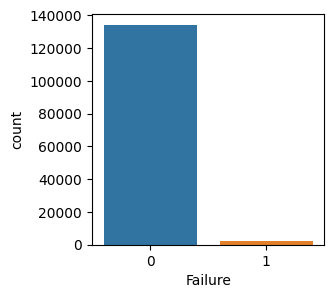

In [ ]:
# Also, Let's go over the balance of data by displaying. It is obviously unbalanced dataset.

sns.countplot(x = 'Failure', data=data)

###Preparation

In [ ]:
# Are there any missing values?
print(data.isnull().values.sum() == 0)

# Checking for duplicate rows
print(data.duplicated().sum())

True
1134


In [ ]:
MEE_encoder = MEstimateEncoder()


target = data['Failure']

# data.drop('Failure', axis=1, inplace=True)
feature_list = list(data.columns)[1:-1]

train_mee = MEE_encoder.fit_transform(data[feature_list], target)

train_mee['pId'] = data['pId']
train_mee['Failure'] = data['Failure']


In [ ]:
# feature_list = list(train_mee.columns)[:-2]
# data_grouped = train_mee.groupby('pId').agg('min')

## Relationships between variables

In [ ]:
# Correlation between target and features
train = train_mee.copy()

NUMERICAL = [col for col in train.select_dtypes("number")]
train[NUMERICAL].drop("Failure", axis=1).apply(lambda x: x.corr(train.Failure))

Type           0.012076
AirTemp        0.067744
ProcessTemp    0.030966
RotSpeed      -0.060868
Torque         0.145793
ToolWear       0.056448
TWF            0.311919
HDF            0.564507
PWF            0.383941
OSF            0.494668
RNF            0.001428
dtype: float64

In [ ]:
def corr_matrix(corr, title="Imbalanced Correlation Matrix"):

  # Sample figsize in inches
  fig, ax = plt.subplots(figsize=(8, 8))

  sns.heatmap(corr,
              cbar=True,
              annot=True,
              square=True,
              fmt='.2f',
              cmap='YlGnBu',
              annot_kws={'size':12},
              ax=ax)
  ax.set_title(title, fontsize=14)
  plt.show()

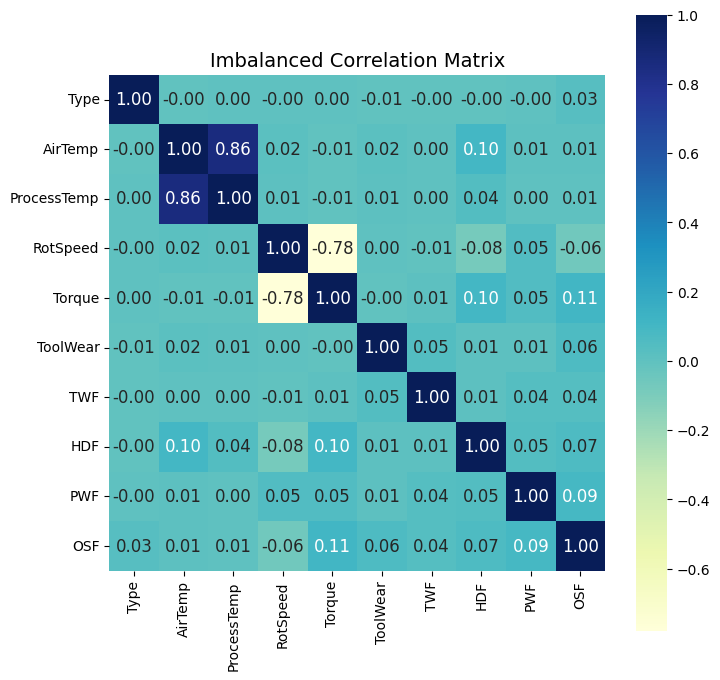

In [ ]:
X = train.drop('RNF', axis=1).iloc[:,:-2]
y = train['Failure']

corr = X.corr()
corr_matrix(corr)

In [ ]:
ros = RandomOverSampler(random_state=SEED)
X_resampled, y_resampled = ros.fit_resample(X, y)
print(f"Imbalanced data length: {len(X)} and balanced data length: {len(X_resampled)}")

Imbalanced data length: 136429 and balanced data length: 268562


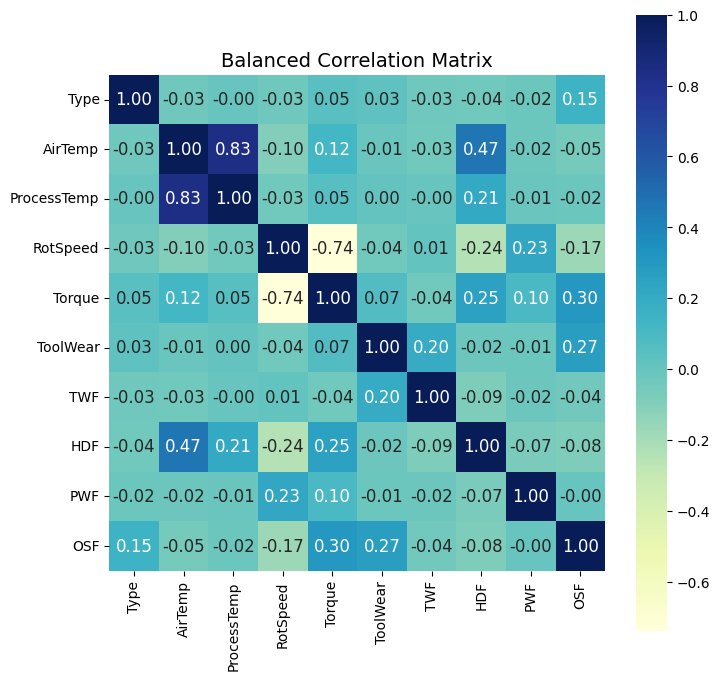

In [ ]:
corr = X_resampled.corr()
corr_matrix(corr, title="Balanced Correlation Matrix")

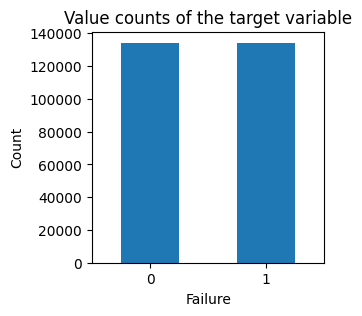

In [ ]:
y_resampled.value_counts().plot(kind="bar")
plt.title("Value counts of the target variable")
plt.xlabel("Failure")
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.show()

In [ ]:
scaler = preprocessing.RobustScaler()
X_scl = scaler.fit_transform(X_resampled)

## Models

###1.XGBClassifier

In [ ]:
%%time
param_grid = {
    'n_estimators': [200, 300],
    'learning_rate': [0.3, 0.5],
    'booster': ['gbtree', 'gblinear'],
    'reg_alpha': [0.5],
    'reg_lambda': [0.2, 0.5],
    'base_score': [0.1, 0.2]
}
xgb = XGBClassifier(random_state=SEED)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=2, random_state=SEED)

search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring="roc_auc", cv=cv)
search_xgb.fit(X_scl, y_resampled, verbose=False)

CPU times: user 1h 38min 52s, sys: 9.64 s, total: 1h 39min 2s
Wall time: 57min 17s


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=3, random_state=42),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importa...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             param_grid={'base_score': [0.1, 0.2],
                         'booster': ['gbtree', 'gblinear'],
                         'learning_rate': [0.3, 0.5],
                         'n_estimators': [200, 300], 'reg_alpha': [0.5],
                         'reg_lambda': [0.2, 0.5]},
             scoring='roc_auc')

In [ ]:
def results_grid(search):

  results_df = pd.DataFrame(search.cv_results_)
  results_df = results_df.sort_values(by=["rank_test_score"])
  results_df = results_df.set_index(
      results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
  ).rename_axis("kernel")
  return results_df

####Score Results

In [ ]:
results_df = results_grid(search_xgb)
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
0.1_gbtree_0.5_300_0.5_0.2,"{'base_score': 0.1, 'booster': 'gbtree', 'lear...",1,0.999916,0.000032
0.2_gbtree_0.5_300_0.5_0.2,"{'base_score': 0.2, 'booster': 'gbtree', 'lear...",2,0.999915,0.000031
0.1_gbtree_0.5_300_0.5_0.5,"{'base_score': 0.1, 'booster': 'gbtree', 'lear...",3,0.999912,0.000034
0.2_gbtree_0.5_300_0.5_0.5,"{'base_score': 0.2, 'booster': 'gbtree', 'lear...",4,0.999911,0.000026
0.1_gbtree_0.5_200_0.5_0.5,"{'base_score': 0.1, 'booster': 'gbtree', 'lear...",5,0.999899,0.000037
0.2_gbtree_0.5_200_0.5_0.2,"{'base_score': 0.2, 'booster': 'gbtree', 'lear...",6,0.999898,0.000036
0.1_gbtree_0.5_200_0.5_0.2,"{'base_score': 0.1, 'booster': 'gbtree', 'lear...",7,0.999898,0.000034
0.2_gbtree_0.3_300_0.5_0.2,"{'base_score': 0.2, 'booster': 'gbtree', 'lear...",8,0.999896,0.000035
0.1_gbtree_0.3_300_0.5_0.5,"{'base_score': 0.1, 'booster': 'gbtree', 'lear...",9,0.999894,0.000038


###2.CatBoostClassifier

In [ ]:
%%time
param_grid = {
    'iterations': [100, 300, 500],
    'learning_rate': [0.03, 0.05, 1]
}
cat = CatBoostClassifier(depth=2)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=2, random_state=SEED)

searchCat = GridSearchCV(estimator=cat, param_grid=param_grid, scoring="roc_auc", cv=cv)
searchCat.fit(X_scl, y_resampled, verbose=False)

CPU times: user 12min 34s, sys: 15.6 s, total: 12min 50s
Wall time: 8min 7s


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=3, random_state=42),
             estimator=<catboost.core.CatBoostClassifier object at 0x7a215b2d3280>,
             param_grid={'iterations': [100, 300, 500],
                         'learning_rate': [0.03, 0.05, 1]},
             scoring='roc_auc')

####Score Results

In [ ]:
results_grid(searchCat)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_iterations,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
kernel,,,,,,,,,,,,,,,,
500_1,13.532254,0.743490,0.277721,0.010744,500,1,"{'iterations': 500, 'learning_rate': 1}",0.995964,0.996336,0.996137,0.996417,0.995893,0.996235,0.996164,0.000188,1
300_1,8.457658,0.902192,0.267379,0.004692,300,1,"{'iterations': 300, 'learning_rate': 1}",0.993005,0.993591,0.993253,0.993447,0.993031,0.993376,0.993284,0.000213,2
100_1,2.046291,0.394692,0.317315,0.130255,100,1,"{'iterations': 100, 'learning_rate': 1}",0.981649,0.983224,0.983203,0.982638,0.982117,0.981722,0.982426,0.000643,3
500_0.05,13.817297,0.099607,0.273002,0.003160,500,0.05,"{'iterations': 500, 'learning_rate': 0.05}",0.971553,0.973788,0.972982,0.973427,0.972685,0.972066,0.972750,0.000763,4
300_0.05,9.117430,1.201044,0.404034,0.136564,300,0.05,"{'iterations': 300, 'learning_rate': 0.05}",0.967654,0.969823,0.969043,0.969605,0.968818,0.968041,0.968830,0.000779,5
500_0.03,14.698508,1.333047,0.335978,0.111593,500,0.03,"{'iterations': 500, 'learning_rate': 0.03}",0.967646,0.969484,0.968968,0.969434,0.968674,0.968022,0.968705,0.000683,6
300_0.03,9.331558,0.964324,0.374055,0.141953,300,0.03,"{'iterations': 300, 'learning_rate': 0.03}",0.964210,0.966336,0.965637,0.966163,0.965494,0.964750,0.965432,0.000748,7
100_0.05,2.099944,0.535744,0.307335,0.108434,100,0.05,"{'iterations': 100, 'learning_rate': 0.05}",0.956535,0.959290,0.958986,0.958958,0.958312,0.958040,0.958354,0.000917,8
100_0.03,2.274755,0.919396,0.268461,0.017002,100,0.03,"{'iterations': 100, 'learning_rate': 0.03}",0.952715,0.955142,0.955250,0.954783,0.954267,0.953898,0.954342,0.000867,9


###Save Best Estimator

In [ ]:
import joblib

#save your model or results
joblib.dump(search_xgb.best_estimator_, '/content/gdrive/My Drive/xgbClassifier.pkl')

#load your model for further usage
xgb = joblib.load("/content/gdrive/My Drive/xgbClassifier.pkl")

#from sklearn.externals import joblib
#joblib.dump(searchCat.best_estimator_, '/content/gdrive/My Drive/CatClassifierBest.pkl')
#CatModel = joblib.load("/content/gdrive/My Drive/CatClassifierBest.pkl")

['/content/gdrive/My Drive/CatClassifierBest.pkl']

##Test Data

In [ ]:
test = pd.read_csv('test.csv')
test.drop('id', axis=1, inplace=True)
test.iloc[:,2:].describe().T

,count,mean,std,min,25%,50%,75%,max
Air temperature [K],90954.0,299.859493,1.857562,295.3,298.3,300.0,301.2,304.4
Process temperature [K],90954.0,309.939375,1.385296,305.7,308.7,310.0,310.9,313.8
Rotational speed [rpm],90954.0,1520.528179,139.970419,1168.0,1432.0,1493.0,1579.0,2886.0
Torque [Nm],90954.0,40.335191,8.504683,3.8,34.6,40.5,46.2,76.6
Tool wear [min],90954.0,104.293962,63.871092,0.0,48.0,106.0,158.0,253.0
TWF,90954.0,0.001473,0.038355,0.0,0.0,0.0,0.0,1.0
HDF,90954.0,0.005343,0.072903,0.0,0.0,0.0,0.0,1.0
PWF,90954.0,0.002353,0.048449,0.0,0.0,0.0,0.0,1.0
OSF,90954.0,0.003870,0.062090,0.0,0.0,0.0,0.0,1.0
RNF,90954.0,0.002309,0.047995,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Checking for duplicate rows
print(test.duplicated().sum())

# Are there any missing values?
print(test[test.isnull()].sum())

523
Product ID                   0
Type                         0
Air temperature [K]        0.0
Process temperature [K]    0.0
Rotational speed [rpm]     0.0
Torque [Nm]                0.0
Tool wear [min]            0.0
TWF                        0.0
HDF                        0.0
PWF                        0.0
OSF                        0.0
RNF                        0.0
dtype: object


In [ ]:
test = rename_columns_label_encoding(test)
test.head()

,pId,Type,AirTemp,ProcessTemp,RotSpeed,Torque,ToolWear,TWF,HDF,PWF,OSF,RNF
0,L50896,L,302.3,311.5,1499,38.0,60,0,0,0,0,0
1,L53866,L,301.7,311.0,1713,28.8,17,0,0,0,0,0
2,L50498,L,301.3,310.4,1525,37.7,96,0,0,0,0,0
3,M21232,M,300.1,309.6,1479,47.6,5,0,0,0,0,0
4,M19751,M,303.4,312.3,1515,41.3,114,0,0,0,0,0


In [ ]:
test = test.iloc[:, 1:]
test_mee = MEE_encoder.transform(test)
test_mee

,Type,AirTemp,ProcessTemp,RotSpeed,Torque,ToolWear,TWF,HDF,PWF,OSF,RNF
0,0.016727,302.3,311.5,1499,38.0,60,0,0,0,0,0
1,0.016727,301.7,311.0,1713,28.8,17,0,0,0,0,0
2,0.016727,301.3,310.4,1525,37.7,96,0,0,0,0,0
3,0.013592,300.1,309.6,1479,47.6,5,0,0,0,0,0
4,0.013592,303.4,312.3,1515,41.3,114,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
90949,0.016727,302.3,311.4,1484,40.4,15,0,0,0,0,0
90950,0.016727,297.9,309.8,1542,33.8,31,0,0,0,0,0
90951,0.016727,295.6,306.2,1501,41.4,187,0,0,0,0,0
90952,0.016727,298.1,307.8,1534,40.3,69,0,0,0,0,0


In [ ]:
#scaler = preprocessing.RobustScaler()
X_test = scaler.fit_transform(test_mee.iloc[:,:-1])

In [ ]:
y_pred = xgb.predict(X_test)
df = pd.DataFrame(data=y_pred, columns=['Machine failure'])

In [ ]:
df.to_csv('/content/gdrive/My Drive/machineFailurePrediction.csv', index=False)
# df = pd.read_csv('/content/gdrive/My Drive/machineFailurePrediction.csv')

In [ ]:
# Done